In [236]:
import argparse
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from tqdm import tqdm
import struct
import pickle
from scipy.interpolate import RectBivariateSpline
import scipy as sp
import os
import glob
import numpy as np
np.seterr('raise')
from sklearn.linear_model import LinearRegression
import seaborn as sns
np.set_printoptions(precision=4)

%matplotlib notebook

def read_complex_binary2(filename):
    """ Read file of float32 into complex array.
    """

    with open(filename, 'rb') as f:
        bytes = f.read()
    data = np.frombuffer(bytes, dtype=np.float32).reshape(-1, 2)
    data = data[:, 0] + 1j*data[:, 1]
    return data

def get_rssis(filename):
    """ Get RSSI time series from file.
    """
    rssis = []
    data = read_complex_binary2(filename)
    num_frame = int(len(data)/65536 - 2)
    for i in range(num_frame):
        section = data[i*65536:(i+1)*65536]
        spectrum = 10*np.log10(np.fft.fftshift(np.abs(np.fft.fft(section))**2))
        rssis.append(np.max(spectrum[22929:22949]))
    rssis = np.array(rssis)
    return rssis

def get_test_grid(dirname, prefix, xs=None, ys=None):
    """ Get test grid from xs, ys.
    """
    test_rssis = {}
    
    if xs is None or ys is None:
        for filename in tqdm(glob.glob(os.path.join(dirname, f"{prefix}*.dat"))):
            coords = os.path.splitext(os.path.basename(filename))[0][1:]
            x, y = int(coords[:2]), int (coords[2:])
            
            filename_cached = os.path.splitext(filename)[0] + '.pkl'
            if os.path.exists(filename_cached):
                with open(filename_cached, 'rb') as f:
                    mean, std = pickle.load(f)
                test_rssis[x,y] = mean
            else:
                rssis = get_rssis(filename)
                if len(rssis):
                    mean, std = np.mean(rssis), np.std(rssis)
                    with open(filename_cached, 'wb') as f:
                        pickle.dump((mean,std), f)
                    test_rssis[x,y] = mean
                
    else:
        for i, x in enumerate(tqdm(xs)):
            for j, y in enumerate(ys):
                filename = os.path.join(dirname, f"{prefix}{x:>02}{y:>02}.dat")
                filename_cached = os.path.splitext(filename)[0] + '.pkl'
                if os.path.exists(filename_cached):
                    with open(filename_cached, 'rb') as f:
                        mean, std = pickle.load(f)
                    test_rssis[x,y] = mean
                else:
                    rssis = get_rssis(filename)
                    if len(rssis):
                        mean, std = np.mean(rssis), np.std(rssis)
                        with open(filename_cached, 'wb') as f:
                            pickle.dump((mean,std), f)
                        test_rssis[x,y] = mean
    
    return test_rssis

# MLE

In [307]:
def get_model_mle(dirname, prefix, xs, ys):
    """ Get the likelihood model from directory of data files.
    """
    s_mean = np.full_like(np.meshgrid(xs,ys)[0], np.nan, dtype=np.float64)
    s_dev  = np.full_like(np.meshgrid(xs,ys)[0], np.nan, dtype=np.float64)

    for i, x in enumerate(tqdm(xs)):
        for j, y in enumerate(ys):
            filename = os.path.join(dirname, f"{prefix}{x:>02}{y:>02}.dat")
            filename_cached = os.path.splitext(filename)[0] + '.pkl'
            if os.path.exists(filename_cached):
                with open(filename_cached, 'rb') as f:
                    mean, std = pickle.load(f)
                s_mean[i,j] = mean
                s_dev[i,j] = std
            else:
                rssis = get_rssis(filename)
                if len(rssis):
                    mean, std = np.mean(rssis), np.std(rssis)
                    with open(filename_cached, 'wb') as f:
                        pickle.dump((mean,std), f)
                    s_mean[i,j] = mean
                    s_dev[i,j] = std
            
    f_mean = RectBivariateSpline(xs, ys, s_mean)
    f_dev = RectBivariateSpline(xs, ys, s_dev)
    
    return f_mean, f_dev 

def log_normal_pdf(x, mean, stddev):
    """ Compute log of normal pdf.
    """
    result = -0.5*np.log(2*np.pi*stddev**2) - (x-mean)**2/(2*stddev**2)
    return result

def calc_log_likelihood(rssis, x, y, f_mean, f_dev, c=0, n=0):
    """ Compute likelihood of observing 4 rssis measurements given the ground truth
        location is x, y for a model given by f_mean, f_dev.
    """

    log_likelihood = 0.0
    log_likelihood += log_normal_pdf(rssis[0], f_mean(x, y) + c, f_dev(x, y))
    log_likelihood += log_normal_pdf(rssis[1], f_mean(n-y, x) + c, f_dev(n-y, x))
    log_likelihood += log_normal_pdf(rssis[2], f_mean(n-x, n-y) + c, f_dev(n-x, n-y))
    log_likelihood += log_normal_pdf(rssis[3], f_mean(y, n-x) + c, f_dev(y, n-x))
    return log_likelihood

def localize_mle(rssis, f_mean, f_dev, ls, n):
    """ Compute location estimate using maximum-likelihood estimation.
    """
    xs = np.arange(0, n+0.1, 0.1)
    ys = np.arange(0, n+0.1, 0.1)
    
    likelihood_grid = np.zeros_like(np.meshgrid(xs,ys,ls)[0], dtype=np.float64)
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            for k, l in enumerate(ls):
                likelihood_grid[i,j,k] = calc_log_likelihood(rssis, x, y, f_mean, f_dev, l, n)
    result = np.unravel_index(np.argmax(likelihood_grid), likelihood_grid.shape)
    
    return result[0]/10.0, result[1]/10.0, result[2]

def run_mle(dirname, n,
            train_prefix, test_prefix, 
            train_xs, train_ys, test_xs, test_ys):
    
    test_grid     = get_test_grid(dirname, test_prefix, test_xs, test_ys)
    f_mean, f_dev = get_model_mle(dirname, train_prefix, train_xs, train_ys)

    errors = []
    prediction_record=[]
    for (x,y) in tqdm(test_grid.keys()):
        rssis = [test_grid[x, y], 
                 test_grid[n-y, x],
                 test_grid[n-x, n-y], 
                 test_grid[y, n-x]]
        x_pred, y_pred, l = localize_mle(rssis, f_mean, f_dev, np.arange(-3, 10), n)
        errors.append(np.sqrt((x-x_pred)**2+(y-y_pred)**2))
        prediction_record.append([x,y,x_pred,y_pred,l])
    print(f"mean error: {np.mean(errors)}")
    print(f"median error: {np.median(errors)}")
    print(f"stdev error: {np.std(errors)}")
    
    return errors, prediction_record

In [310]:
errors_mle = []

# Dataset
dirname = 'data/Sep 17- redo water'
n = 10 # grid is 0 to n (n+1 by n+1)
# AEM*
train_prefix = 0
train_xs = np.arange(0,n+1,2)
train_ys = np.arange(0,n+1,2)
test_prefix = 1
# Run prediction
errors, prediction_record = run_mle(dirname, n,
                                    train_prefix, test_prefix,
                                    train_xs, train_ys, None, None)
errors_mle += errors
with open(f'error_mle_{os.path.basename(dirname)}.pkl', 'wb') as f:
    pickle.dump(errors, f)
with open(f'pred_mle_{os.path.basename(dirname)}.pkl', 'wb') as f:
    pickle.dump(prediction_record, f)

# Dataset
dirname = 'data/sep-18-first'
n = 10 # grid is 0 to n (n+1 by n+1)
# AEM*
train_prefix = 0
train_xs = np.arange(0,n+1,2)
train_ys = np.arange(0,n+1,2)
test_prefix = 1
# Run prediction
errors, prediction_record = run_mle(dirname, n,
                                    train_prefix, test_prefix,
                                    train_xs, train_ys, None, None)
errors_mle += errors
with open(f'error_mle_{os.path.basename(dirname)}.pkl', 'wb') as f:
    pickle.dump(errors, f)
with open(f'pred_mle_{os.path.basename(dirname)}.pkl', 'wb') as f:
    pickle.dump(prediction_record, f)

# Dataset
# dirname = 'data/sep-19-full'
# n = 10 # grid is 0 to n (n+1 by n+1)
# # AEM*
# train_prefix = 0
# train_xs = np.arange(0,n+1,2)
# train_ys = np.arange(0,n+1,2)
# test_prefix = 1
# # Run prediction
# errors, prediction_record = run_mle(dirname, n,
#                                     train_prefix, test_prefix,
#                                     train_xs, train_ys, None, None)
# errors_mle += errors
# with open(f'pred_mle_{os.path.basename(dirname)}.pkl', 'wb') as f:
#     pickle.dump(prediction_record, f)

# # Dataset
# dirname = 'data/sep-20-redo'
# n = 10 # grid is 0 to n (n+1 by n+1)
# # AEM*
# train_prefix = 0
# train_xs = np.arange(0,n+1,2)
# train_ys = np.arange(0,n+1,2)
# test_prefix = 1
# # Run prediction
# errors, prediction_record = run_mle(dirname, n,
#                                     train_prefix, test_prefix,
#                                     train_xs, train_ys, None, None)
# errors_mle += errors
# with open(f'pred_mle_{os.path.basename(dirname)}.pkl', 'wb') as f:
#     pickle.dump(prediction_record, f)

# with open('errors_mle.pkl', 'wb') as f:
#     pickle.dump(errors_mle, f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [17:25<00:00,  8.64s/it]


mean error: 0.9304331509785079
median error: 0.8602325267042628
stdev error: 0.6171756004640324


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [05:06<00:00,  8.52s/it]

mean error: 0.26033601572203235
median error: 0.28284271247461845
stdev error: 0.10001468240091278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 8001.85it/s]


<IPython.core.display.Javascript object>


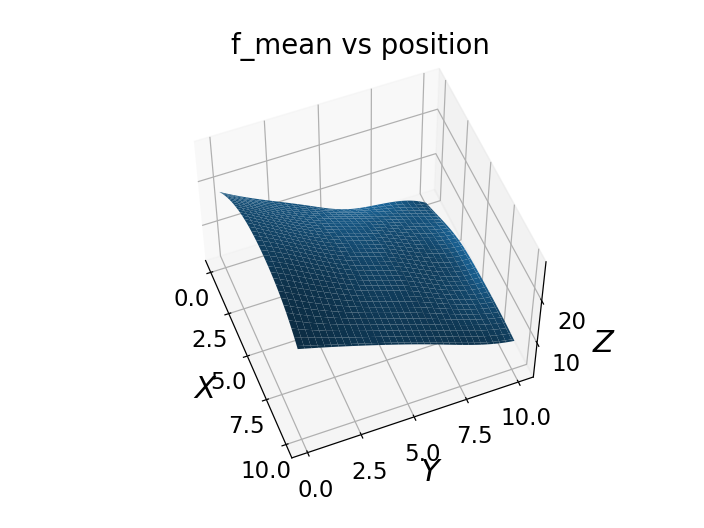

<IPython.core.display.Javascript object>


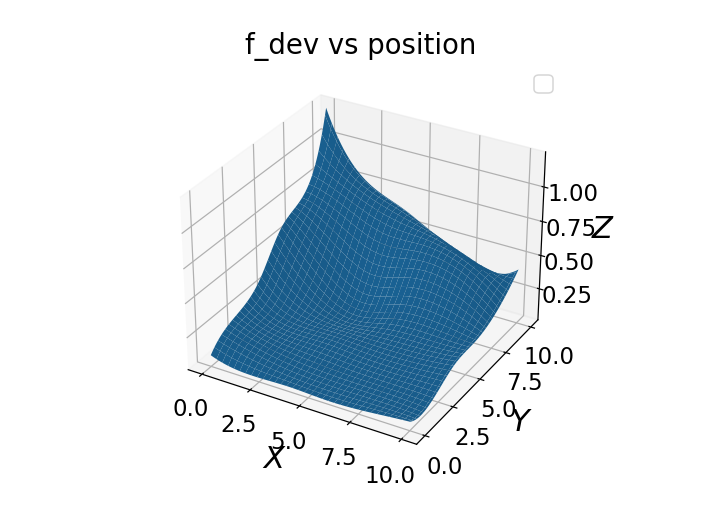

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [300]:
plt.rcParams.update({'font.size': 15})

dataset = 'data/sep-20-redo'

f_mean, f_dev = get_model_mle(dataset, 0, np.arange(0,n+1,2), np.arange(0,n+1,2))

x, y = np.meshgrid(np.arange(0,n+0.1,0.1), np.arange(0,n+0.1,0.1))
z = f_mean(x, y, grid=False)
# z = f_mean_points
# x, y = np.meshgrid(np.arange(z.shape[0]), np.arange(z.shape[1]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)
ax.set_title('f_mean vs position')
ax.set_xlabel('$X$', fontsize=20)
ax.set_ylabel('$Y$', fontsize=20)
ax.set_zlabel('$Z$', fontsize=20)
fig.show()

x, y = np.meshgrid(np.arange(0,n+0.1,0.1), np.arange(0,n+0.1,0.1))
z = f_dev(x, y, grid=False)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)
ax.legend()
ax.set_title('f_dev vs position')
ax.set_xlabel('$X$', fontsize=20)
ax.set_ylabel('$Y$', fontsize=20)
ax.set_zlabel('$Z$', fontsize=20)
fig.show()



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 8501.97it/s]


<IPython.core.display.Javascript object>


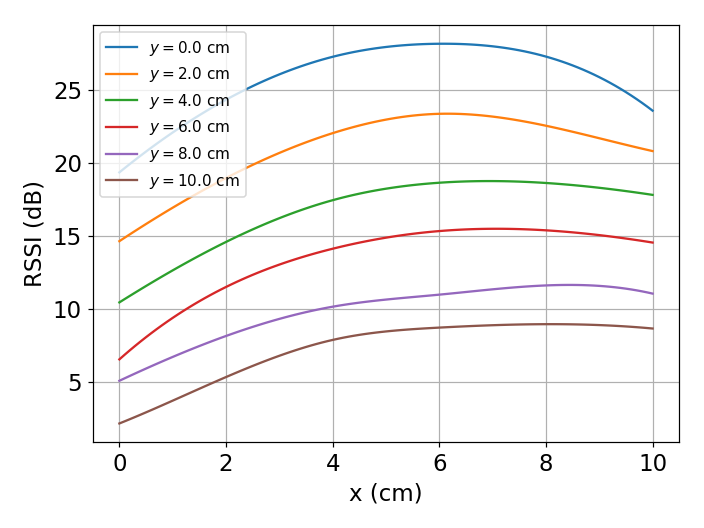

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 8316.53it/s]


<IPython.core.display.Javascript object>


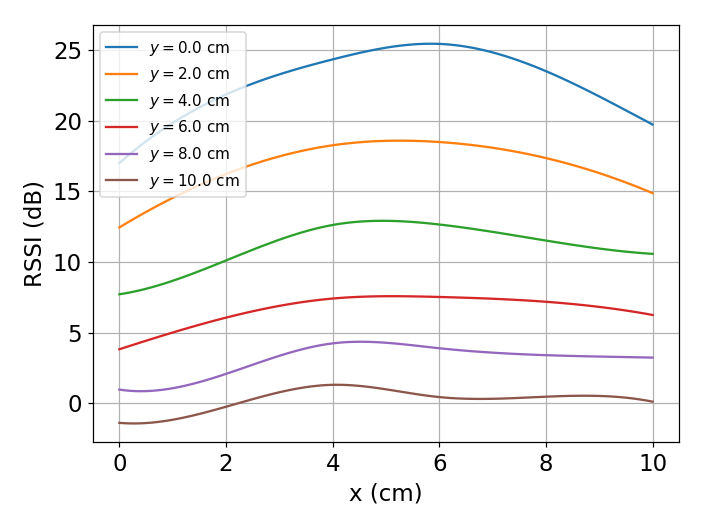

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10309.64it/s]


<IPython.core.display.Javascript object>


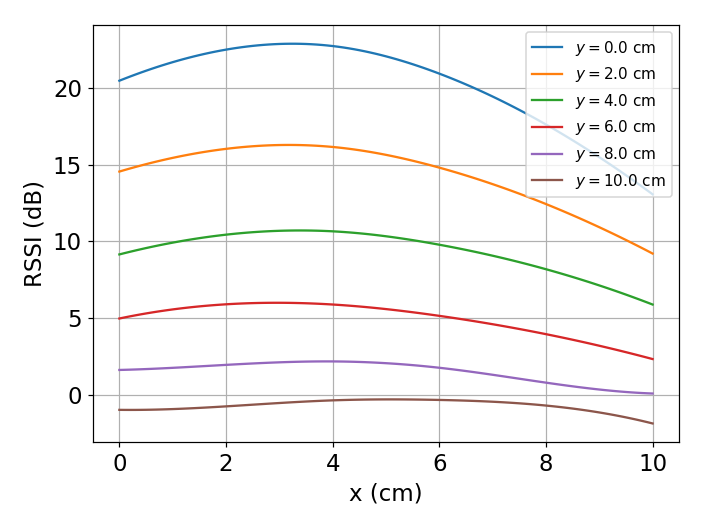

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 7609.87it/s]


<IPython.core.display.Javascript object>


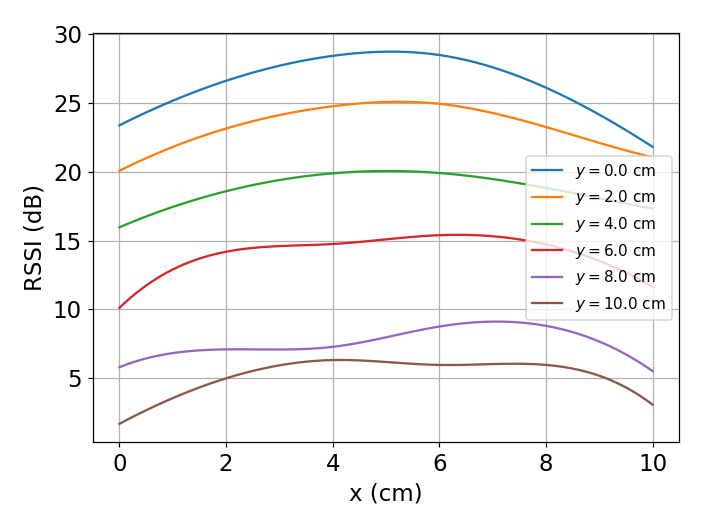

In [304]:
plt.rcParams.update({'font.size': 15})

datasets = ['data/sep-20-redo', 'data/sep-19-full', 'data/sep-18-first', 'data/Sep 17- redo water']

for dataset in datasets:
    f_mean, f_dev = get_model_mle(dataset, 0, np.arange(0,n+1,2), np.arange(0,n+1,2))
    
    fig, ax = plt.subplots()
    ys = np.arange(0,n+2.0,2.0)
    xs = np.arange(0,n+0.1,0.1)
    for y in ys:
        ax.plot(xs, [f_mean(x,y)[0,0] for x in xs], label=f"$y = {y}$ cm")
    ax.legend(prop={'size': 10})
    ax.grid()
    ax.set_ylabel('RSSI (dB)')
    ax.set_xlabel('x (cm)')
    fig.tight_layout()
    fig.show()
    plt.savefig(os.path.basename(dataset) + '.png')